<img src="../docs/_static/logo-rsm.png" align="right" width="200">


# Part 4: Monitoring results with TensorBoard

Use `torch.utils.tensorboard.SummaryWriter` to log
1. scalars (e.g., train loss, validation loss)
1. histograms (e.g., weight matrices, gradients)
1. images (e.g., decision boundaries, precision/recall curves)

In [1]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

from src.common import yaml_load
from src.nn import Net, generate_data, plot_spiral, plot_to_image

In [2]:
config = yaml_load("../configs/config.yaml")

## Data

In [3]:
xy_lims = (-20, 20)

In [4]:
X, y = generate_data(N=2_000)

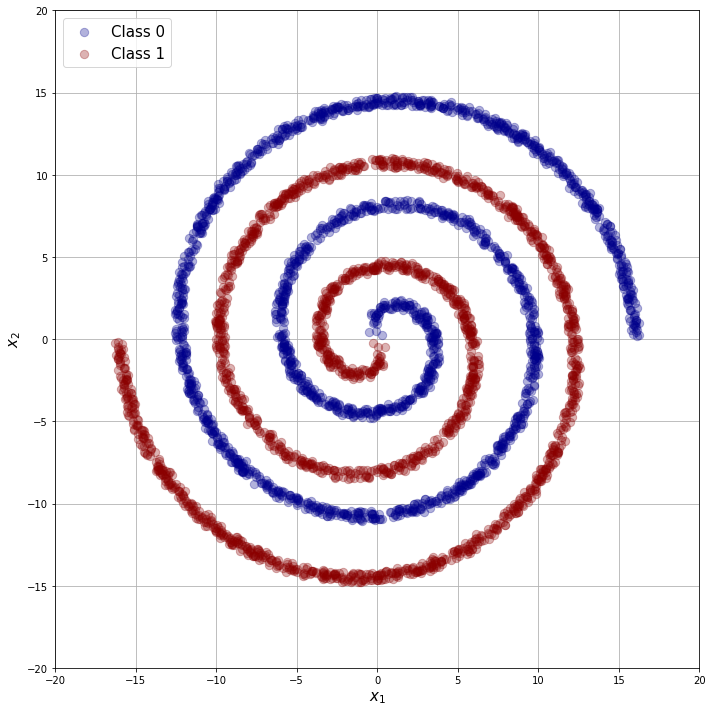

In [5]:
plot_spiral(X, y, xlim=xy_lims, ylim=xy_lims)

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=config["data"]["valid"]["batch_size"],
    random_state=config["seed"],
)

### Data

In [7]:
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

In [8]:
x_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
x_valid = torch.tensor(x_valid)
y_valid = torch.tensor(y_valid)

In [9]:
ds_train = TensorDataset(x_train, y_train)
dl_train = DataLoader(ds_train, **config["data"]["train"])

In [10]:
# for plot
xx = np.linspace(-20, 20, 400)
yy = np.linspace(-20, 20, 400)
gx, gy = np.meshgrid(xx, yy)

### Training

Run TensorBoard during training with
```
tensorboard --logdir=runs_01
```

Open TensorBaord at http://localhost:6006/.

Plot decision boundary with helper function `plot_to_image`.

In [11]:
writer = SummaryWriter("logs")

model = Net(**config["model"])
opt = Adam(model.parameters(), **config["optimizer"])

for epoch in range(config["trainer"]["epochs"]):

    # training
    model.train()
    _loss = []
    for xb, yb in dl_train:
        opt.zero_grad()
        loss_train = binary_cross_entropy_with_logits(model(xb).flatten(), yb)
        loss_train.backward()
        opt.step()
        _loss.append(loss_train.item())

    # evaluation
    model.eval()
    with torch.no_grad():
        loss_valid = binary_cross_entropy_with_logits(model(x_valid).flatten(), y_valid)

    # logging
    writer.add_scalar("loss/train", loss_train, epoch)
    writer.add_scalar("loss/valid", loss_valid, epoch)

    for i in range(len(model.hidden)):
        writer.add_histogram(f"weights/h{i}", model.hidden[i].weight.flatten(), epoch)
        writer.add_histogram(f"weights/b{i}", model.hidden[i].bias, epoch)

    for i in range(len(model.hidden)):
        writer.add_histogram(f"grad/h{i}", model.hidden[i].weight.grad.flatten(), epoch)
        writer.add_histogram(f"grad/b{i}", model.hidden[i].bias.grad, epoch)

    if epoch in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 500, 1000]:
        Z = (
            model(torch.tensor(np.c_[gx.ravel(), gy.ravel()].astype(np.float32)))
            .detach()
            .numpy()
            .reshape(gx.shape)
        )
        writer.add_image("test", plot_to_image(gx, gy, Z), epoch)

writer.flush()
writer.close()

2022-04-02 21:14:50.180874: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<br>
<br>
&mdash; <br>
Sebastian Gabel <br>
Rotterdam School of Management <br>

www.github.com/sbstn-gbl <br>
www.sebastiangabel.com